In [28]:
# reading and preprocessing the data
import numpy as np
import pandas as pd

data_path = "./data/wine_quality.csv"
df = pd.read_csv(data_path, header=0)
# dropping first two columns (since they only include indices not actual data)
df.drop(df.columns[:2], axis=1, inplace=True)
# handling quality and alcohol_level
mapping =  {'high': 1, 'low': 0}
df['quality'] = df['quality'].map(mapping)
df['alcohol_level'] = df['alcohol_level'].map(mapping)
# moving the target variable (quality) to the end of the df
df['quality'] = df.pop('quality')
df.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol_level,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,0,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,0,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,1,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,0,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,0,0


In [29]:
# splitting to train and test set
from sklearn.model_selection import train_test_split
X = df.drop("quality", axis=1)
y = df["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [30]:
# MY GRADIENT BOOSTING
import math
from sklearn.tree import DecisionTreeRegressor

class MyGradientBoosting:
    def __init__(self, number_of_trees=100, learning_rate=0.1, max_depth=2):
        self.initial_probability = 0
        self.number_of_trees = number_of_trees
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        # turn X and y to numpy array (if they are not already)
        if isinstance(X, pd.DataFrame):
            X = X.values
            y = y.values
        n, m = X.shape # n - number of rows, m - number of atributes

        # initial prediction and probability
        initial_prediction = math.log(np.count_nonzero(y == 1) / np.count_nonzero(y == 0))
        initial_probability = np.exp(initial_prediction) / (1 + np.exp(initial_prediction))
        self.initial_probability = initial_probability

        # init the array of predictions and pseudo residuals
        predictions = np.full(n, initial_probability)
        pseudo_residuals = np.zeros(n)

        for _ in range(self.number_of_trees):
            # calculating pseudo residuals (observed - predicted)
            pseudo_residuals = y - predictions

            # building the tree for predicting the pseudo resuduals
            residuals_tree = DecisionTreeRegressor(max_depth=self.max_depth)
            residuals_tree.fit(X, pseudo_residuals)
            
            # calculating new predictions
            predictions += self.learning_rate * residuals_tree.predict(X)
            
            # adding the tree to the chain of trees
            self.trees.append(residuals_tree)
            #print(predictions)
    
    def predict(self, X):
        # turn X to numpy array (if it's not already)
        if isinstance(X, pd.DataFrame):
            X = X.values
        n, m = X.shape # n - number of rows, m - number of atributes
        predictions = np.full(n, self.initial_probability)
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        # returns y predictions
        return np.round(predictions).astype(int)


In [31]:
# reusing my cross validation from v2
import math 
from sklearn.metrics import accuracy_score, f1_score

def k_fold_split(data, k): # returns k folds of the data
    data = np.array(data)
    fold_size = math.ceil(len(data) / k)
    folds = [data[i:i + fold_size] for i in range(0, len(data), fold_size)]
    return folds

def k_fold_cross_validation(model, X, y, k=5):
    if isinstance(X, pd.DataFrame):
        X = np.array(X)
    if isinstance(y, pd.Series):
        y = np.array(y)
    data = np.hstack((X, y.reshape(-1, 1))) # adding y to X as the last column of data
    
    folds = k_fold_split(data, k) # splitting the data into k folds
    scores = []

    for i in range(k):
        # using one of the folds in each iteration for testing, others for training the model
        test_set = folds[i]
        train_set = np.concatenate([folds[j] for j in range(k) if j != i])

        # fitting the model with train set
        model.fit(train_set[:,:-1], train_set[:,-1])
        score = accuracy_score(test_set[:,-1], model.predict(test_set[:,:-1]))
        scores.append(score)
    return np.mean(scores) # returns the mean of accuracy

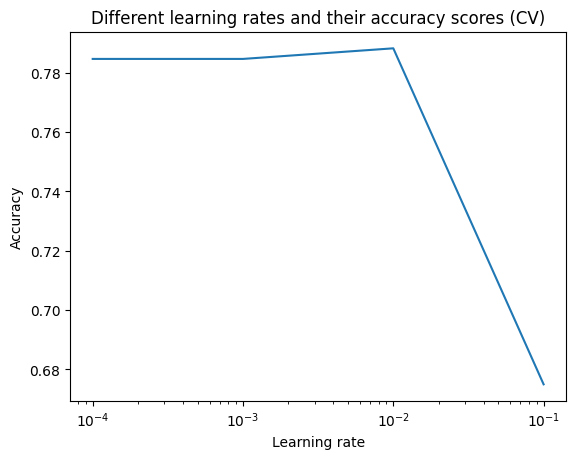

Best learning rate: 0.01


In [32]:
# trying differnet learning rates
possible_learning_rates = [0.0001, 0.001, 0.01, 0.1]
accuracy_scores = []
best_score = -1
best_learning_rate = -1
for lr in possible_learning_rates:    
    my_GB = MyGradientBoosting(learning_rate=lr)
    score = k_fold_cross_validation(my_GB, X_train, y_train)
    accuracy_scores.append(score)
    if score > best_score:
        best_score = score
        best_learning_rate = lr

import matplotlib.pyplot as plt

plt.plot(possible_learning_rates, accuracy_scores)
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Different learning rates and their accuracy scores (CV)')
plt.show()

print("Best learning rate:", best_learning_rate)

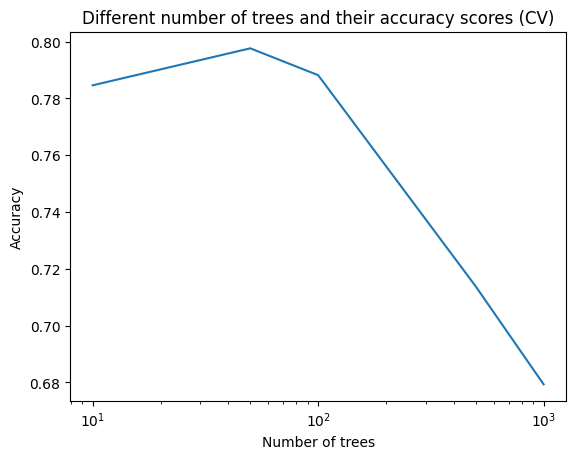

Best number of trees: 50


In [33]:
# trying differenc number of trees

possible_number_of_trees = [10, 50, 100, 500, 1000]
accuracy_scores = []
best_score = -1
best_number_of_trees = -1
for tree_num in possible_number_of_trees:    
    my_GB = MyGradientBoosting(learning_rate=0.01, number_of_trees=tree_num)
    score = k_fold_cross_validation(my_GB, X_train, y_train)
    accuracy_scores.append(score)
    if score > best_score:
        best_score = score
        best_number_of_trees = tree_num

import matplotlib.pyplot as plt

plt.plot(possible_number_of_trees, accuracy_scores)
plt.xscale('log')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Different number of trees and their accuracy scores (CV)')
plt.show()

print("Best number of trees:", best_number_of_trees)

In [34]:
# testing on test set

my_GB = MyGradientBoosting(number_of_trees=50, learning_rate=0.01)
my_GB.fit(X_train, y_train)
y_pred = my_GB.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("My GB accuracy on test set:", accuracy)

My GB accuracy on test set: 0.7795918367346939


Prevent overfitting strategies for my gradient boosting:
- using small learning rate
- using shallow trees

In [35]:
# testing sklearn's gradient boost on test set

from sklearn.ensemble import GradientBoostingClassifier

sklearn_GB = GradientBoostingClassifier()
sklearn_GB.fit(X_train, y_train)
y_pred = sklearn_GB.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Sklearn's GB accuracy on test set:", accuracy)

Sklearn's GB accuracy on test set: 0.8326530612244898


In [36]:
# testing XGBoost on test set

import xgboost as xgb

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("XGBoost's accuracy on test set:", accuracy)

XGBoost's accuracy on test set: 0.8683673469387755


In [37]:
# testing LightGBM on test set

import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 8,
    'learning_rate': 0.01,
    'feature_fraction': 0.9
}
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
print()
print("LightGBM's accuracy on test set:", accuracy)

[LightGBM] [Info] Number of positive: 844, number of negative: 3074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1254
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215416 -> initscore=-1.292582
[LightGBM] [Info] Start training from score -1.292582

LightGBM's accuracy on test set: 0.7795918367346939


In [38]:
# Note: I couldn't build CatBoost model as it would not install on my PC.